In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
from IPython.core.display import display, HTML
import pandas as pd
%reload_ext autoreload
%autoreload 1
%matplotlib inline

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import sys
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

print(sys.version)

3.6.4 |Anaconda custom (64-bit)| (default, Mar 13 2018, 01:15:57) 
[GCC 7.2.0]


In [3]:
print(spark.version)

2.4.0-cdh6.1.0


In [4]:
import pandas as pd
import numpy as np

from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
# from pyspark.ml.feature import OneHotEncoderEstimator
# OneHotEncoderEstimator is available starting from Spark 2.3
from pyspark.ml.classification import LogisticRegression, LogisticRegressionModel
from pyspark.ml.evaluation import BinaryClassificationEvaluator

from pyspark.sql.functions import *
from pyspark.sql.types import *

In [5]:
!ls -l -h '/project/msca/kadochnikov/data/air_travel'

total 1.3G
-rwxr-xr-x 1 kadochnikov kadochnikov 671M Nov  4  2016 2007.csv
-rwxr-xr-x 1 kadochnikov kadochnikov 658M Nov  4  2016 2008.csv


In [6]:
#Pull the dataset from Linux directory
aircraft_2007 = spark.read.csv('file:///project/msca/kadochnikov/data/air_travel/2007.csv', header=True, inferSchema=True)
aircraft_2007.cache()
aircraft_2007.limit(100).toPandas().head(5)

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2007,1,1,1,1232,1225,1341,1340,WN,2891,N351,69,75,54,1,7,SMF,ONT,389,4,11,0,None,0,0,0,0,0,0
1,2007,1,1,1,1918,1905,2043,2035,WN,462,N370,85,90,74,8,13,SMF,PDX,479,5,6,0,None,0,0,0,0,0,0
2,2007,1,1,1,2206,2130,2334,2300,WN,1229,N685,88,90,73,34,36,SMF,PDX,479,6,9,0,None,0,3,0,0,0,31
3,2007,1,1,1,1230,1200,1356,1330,WN,1355,N364,86,90,75,26,30,SMF,PDX,479,3,8,0,None,0,23,0,0,0,3
4,2007,1,1,1,831,830,957,1000,WN,2278,N480,86,90,74,-3,1,SMF,PDX,479,3,9,0,None,0,0,0,0,0,0


In [7]:
#Pull the dataset from Linux directory
aircraft_2008 = spark.read.csv('file:///project/msca/kadochnikov/data/air_travel/2008.csv', header=True, inferSchema=True)
aircraft_2008.cache()
aircraft_2008.limit(100).toPandas().head(5)

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008,1,3,4,2003,1955,2211,2225,WN,335,N712SW,128,150,116,-14,8,IAD,TPA,810,4,8,0,None,0,NA,NA,NA,NA,NA
1,2008,1,3,4,754,735,1002,1000,WN,3231,N772SW,128,145,113,2,19,IAD,TPA,810,5,10,0,None,0,NA,NA,NA,NA,NA
2,2008,1,3,4,628,620,804,750,WN,448,N428WN,96,90,76,14,8,IND,BWI,515,3,17,0,None,0,NA,NA,NA,NA,NA
3,2008,1,3,4,926,930,1054,1100,WN,1746,N612SW,88,90,78,-6,-4,IND,BWI,515,3,7,0,None,0,NA,NA,NA,NA,NA
4,2008,1,3,4,1829,1755,1959,1925,WN,3920,N464WN,90,90,77,34,34,IND,BWI,515,3,10,0,None,0,2,0,0,0,32


Join the two datasets together to get a larger consolidated one.

In [8]:
aircraft_df = aircraft_2007.union(aircraft_2008)

In [9]:
aircraft_df.cache()

DataFrame[Year: int, Month: int, DayofMonth: int, DayOfWeek: int, DepTime: string, CRSDepTime: int, ArrTime: string, CRSArrTime: int, UniqueCarrier: string, FlightNum: int, TailNum: string, ActualElapsedTime: string, CRSElapsedTime: string, AirTime: string, ArrDelay: string, DepDelay: string, Origin: string, Dest: string, Distance: int, TaxiIn: string, TaxiOut: string, Cancelled: int, CancellationCode: string, Diverted: int, CarrierDelay: string, WeatherDelay: string, NASDelay: string, SecurityDelay: string, LateAircraftDelay: string]

In [10]:
aircraft_df = aircraft_df.toDF(*[c.lower() for c in aircraft_df.columns])

In [11]:
aircraft_df.printSchema()

root
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- dayofmonth: integer (nullable = true)
 |-- dayofweek: integer (nullable = true)
 |-- deptime: string (nullable = true)
 |-- crsdeptime: integer (nullable = true)
 |-- arrtime: string (nullable = true)
 |-- crsarrtime: integer (nullable = true)
 |-- uniquecarrier: string (nullable = true)
 |-- flightnum: integer (nullable = true)
 |-- tailnum: string (nullable = true)
 |-- actualelapsedtime: string (nullable = true)
 |-- crselapsedtime: string (nullable = true)
 |-- airtime: string (nullable = true)
 |-- arrdelay: string (nullable = true)
 |-- depdelay: string (nullable = true)
 |-- origin: string (nullable = true)
 |-- dest: string (nullable = true)
 |-- distance: integer (nullable = true)
 |-- taxiin: string (nullable = true)
 |-- taxiout: string (nullable = true)
 |-- cancelled: integer (nullable = true)
 |-- cancellationcode: string (nullable = true)
 |-- diverted: integer (nullable = true)
 |-- car

There are several columns here that need to be typecasted into a different data type. 

In [12]:
aircraft_df = aircraft_df.withColumn("deptime", aircraft_df["deptime"].cast(FloatType())).\
                          withColumn("arrtime", aircraft_df["arrtime"].cast(FloatType())).\
                          withColumn("arrdelay", aircraft_df["arrdelay"].cast(IntegerType())).\
                          withColumn("depdelay", aircraft_df["depdelay"].cast(IntegerType()))
            
aircraft_df = aircraft_df.withColumn("deptime", aircraft_df["deptime"].cast(IntegerType())).\
                          withColumn("arrtime", aircraft_df["arrtime"].cast(IntegerType()))

In [13]:
aircraft_df.limit(100).toPandas().head(5)

,year,month,dayofmonth,dayofweek,deptime,crsdeptime,arrtime,crsarrtime,uniquecarrier,flightnum,tailnum,actualelapsedtime,crselapsedtime,airtime,arrdelay,depdelay,origin,dest,distance,taxiin,taxiout,cancelled,cancellationcode,diverted,carrierdelay,weatherdelay,nasdelay,securitydelay,lateaircraftdelay
0,2007,1,1,1,1232.0,1225,1341.0,1340,WN,2891,N351,69,75,54,1.0,7.0,SMF,ONT,389,4,11,0,None,0,0,0,0,0,0
1,2007,1,1,1,1918.0,1905,2043.0,2035,WN,462,N370,85,90,74,8.0,13.0,SMF,PDX,479,5,6,0,None,0,0,0,0,0,0
2,2007,1,1,1,2206.0,2130,2334.0,2300,WN,1229,N685,88,90,73,34.0,36.0,SMF,PDX,479,6,9,0,None,0,3,0,0,0,31
3,2007,1,1,1,1230.0,1200,1356.0,1330,WN,1355,N364,86,90,75,26.0,30.0,SMF,PDX,479,3,8,0,None,0,23,0,0,0,3
4,2007,1,1,1,831.0,830,957.0,1000,WN,2278,N480,86,90,74,-3.0,1.0,SMF,PDX,479,3,9,0,None,0,0,0,0,0,0


### 1. Which locations (Origin and Dest pairs) had the worst delays for both arrivals (ArrDelay) and departures (DepDelay).

In [14]:
aircraft_grp_1 = aircraft_df[["origin", "dest", "arrdelay"]].groupBy('origin', 'dest').max()
aircraft_grp_1.orderBy('max(arrdelay)', ascending=False).show(5)

+------+----+-------------+
|origin|dest|max(arrdelay)|
+------+----+-------------+
|   PBI| DTW|         2598|
|   HNL| MSP|         2461|
|   CLT| MSP|         2453|
|   RSW| DTW|         1951|
|   ALO| MSP|         1942|
+------+----+-------------+
only showing top 5 rows



In [15]:
aircraft_grp_2 = aircraft_df[["origin", "dest", "depdelay"]].groupBy('origin', 'dest').max()
aircraft_grp_2.orderBy('max(depdelay)', ascending=False).show(5)

+------+----+-------------+
|origin|dest|max(depdelay)|
+------+----+-------------+
|   PBI| DTW|         2601|
|   CLT| MSP|         2467|
|   HNL| MSP|         2457|
|   ALO| MSP|         1956|
|   RSW| DTW|         1952|
+------+----+-------------+
only showing top 5 rows



### 2. Which locations had fewest delays?

Find the rows where a flight was actually delayed, and get the total count for each Origin/Destination pair. Once sorted, it would give us an idea on which locations had the fewest delays

In [16]:
cols = ["origin", "dest", "arrdelay", "depdelay", "year", "month", "dayofweek"]
aircraft_subset = aircraft_df[cols]
aircraft_subset.count()

14462943

Filter out rows that had an arrival or departure delay

In [17]:
aircraft_subset = aircraft_subset[(aircraft_subset["arrdelay"] > 0.0) |\
                                  (aircraft_subset["depdelay"] > 0.0)]
aircraft_subset.count()

7792035

In [18]:
aircraft_grp_3 = aircraft_subset[["origin", "dest", "arrdelay"]].groupBy('origin', 'dest').count()
aircraft_grp_3.orderBy('count', ascending=True).show(5)

+------+----+-----+
|origin|dest|count|
+------+----+-----+
|   GRB| DEN|    1|
|   ACY| MYR|    1|
|   FSD| PIA|    1|
|   XNA| SGF|    1|
|   PVD| BDL|    1|
+------+----+-----+
only showing top 5 rows



### 3.Do you see any significant seasonality effects for delays?

We can analyse how many delays there have been over 2007 and 2008 on a monthly basis.
First we find the rows that have had either an arrival/departure delay. Then we bin them through month and year.

In [19]:
aircraft_subset.show(5)

+------+----+--------+--------+----+-----+---------+
|origin|dest|arrdelay|depdelay|year|month|dayofweek|
+------+----+--------+--------+----+-----+---------+
|   SMF| ONT|       1|       7|2007|    1|        1|
|   SMF| PDX|       8|      13|2007|    1|        1|
|   SMF| PDX|      34|      36|2007|    1|        1|
|   SMF| PDX|      26|      30|2007|    1|        1|
|   SMF| PDX|      -3|       1|2007|    1|        1|
+------+----+--------+--------+----+-----+---------+
only showing top 5 rows



In [20]:
aircraft_grp_4 = aircraft_subset.groupBy(["year", "month"]).count()
aircraft_grp_4.show(5)

+----+-----+------+
|year|month| count|
+----+-----+------+
|2007|    6|388918|
|2008|    8|301709|
|2007|    1|344800|
|2007|   10|324434|
|2008|    1|334398|
+----+-----+------+
only showing top 5 rows



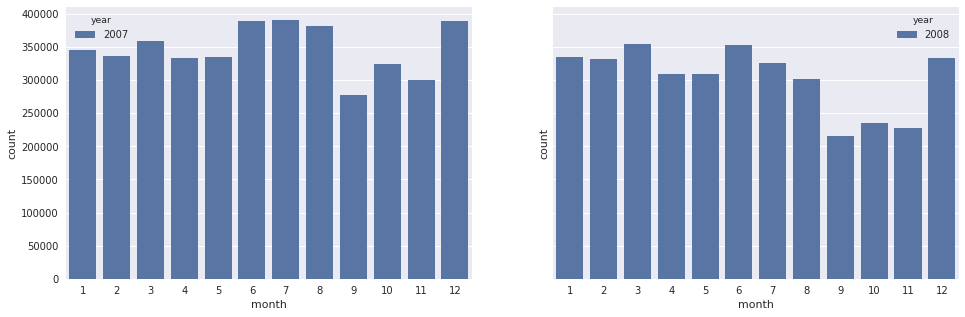

In [21]:
p_grp_4 = aircraft_grp_4.toPandas()

f, ax = plt.subplots(1, 2, figsize=(16,5), sharey=True)
g = sns.barplot(x="month", y="count", data=p_grp_4[p_grp_4["year"]==2007], hue="year", ax=ax[0])
g = sns.barplot(x="month", y="count", data=p_grp_4[p_grp_4["year"]==2008], hue="year", ax=ax[1])

### 4. Do you see any increase or decrease in delays on weekends?

Day 1 corresponds to Monday. The weekends would be days 6 and 7 (saturday and sunday respectively).

In [22]:
aircraft_subset.show(5)

+------+----+--------+--------+----+-----+---------+
|origin|dest|arrdelay|depdelay|year|month|dayofweek|
+------+----+--------+--------+----+-----+---------+
|   SMF| ONT|       1|       7|2007|    1|        1|
|   SMF| PDX|       8|      13|2007|    1|        1|
|   SMF| PDX|      34|      36|2007|    1|        1|
|   SMF| PDX|      26|      30|2007|    1|        1|
|   SMF| PDX|      -3|       1|2007|    1|        1|
+------+----+--------+--------+----+-----+---------+
only showing top 5 rows



In [23]:
aircraft_grp_5 = aircraft_subset.groupBy(["dayofweek"]).count()
aircraft_grp_5.show(5)

+---------+-------+
|dayofweek|  count|
+---------+-------+
|        1|1172293|
|        6| 907038|
|        3|1106115|
|        5|1243443|
|        4|1189164|
+---------+-------+
only showing top 5 rows



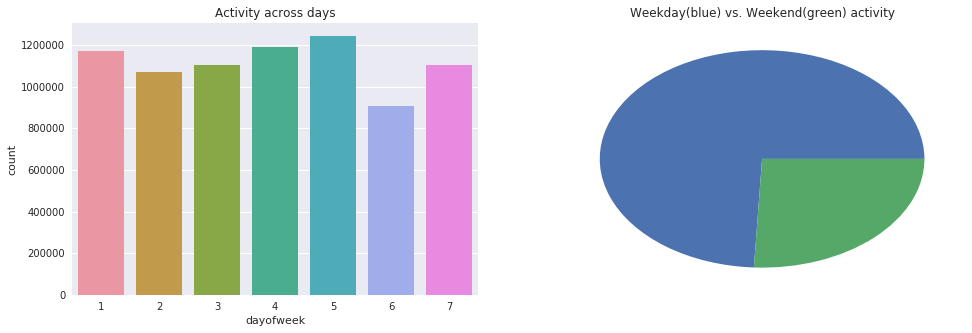

In [24]:
p_grp_5 = aircraft_grp_5.toPandas()

weekday_count = p_grp_5[p_grp_5["dayofweek"] < 6]["count"].sum()
weekend_count = p_grp_5[p_grp_5["dayofweek"] >= 6]["count"].sum()

f, ax = plt.subplots(1, 2, figsize=(16,5))
g = sns.barplot(x="dayofweek", y="count", data=p_grp_5, ax=ax[0])
patches, texts = ax[1].pie(x=[weekday_count, weekend_count])

t = ax[0].set_title("Activity across days")
t = ax[1].set_title("Weekday(blue) vs. Weekend(green) activity")

### 5. Are flights equally distributed throughout the day?
Plot the distribution of DepTime, ArrTime (actual departure and arrival time)

#### Arrival Times

We can bin the times into their respective hours. To do this, we can remove the last 2 characters from each column, and extract the hour.

In [25]:
aircraft_df.orderBy('arrtime', ascending=False).limit(100).toPandas().head(5)

,year,month,dayofmonth,dayofweek,deptime,crsdeptime,arrtime,crsarrtime,uniquecarrier,flightnum,tailnum,actualelapsedtime,crselapsedtime,airtime,arrdelay,depdelay,origin,dest,distance,taxiin,taxiout,cancelled,cancellationcode,diverted,carrierdelay,weatherdelay,nasdelay,securitydelay,lateaircraftdelay
0,2007,1,18,4,2302,2235,2400,2336,DL,1798,N981DL,58,61,33,24,27,ATL,CLT,227,5,20,0,None,0,13,0,0,0,11
1,2007,1,12,5,2058,2000,2400,2325,B6,629,N534JB,182,205,147,35,58,JFK,HOU,1428,6,29,0,None,0,0,0,2,0,33
2,2007,1,21,7,1804,1719,2400,2330,DL,1215,N658DL,236,251,216,30,45,SLC,MCO,1929,6,14,0,None,0,13,0,0,0,17
3,2007,1,6,6,1854,1835,2400,2340,WN,756,N321,186,185,176,20,19,LAX,MCI,1363,4,6,0,None,0,0,0,4,0,16
4,2007,1,26,5,2104,2105,2400,8,DL,1035,N660DL,296,303,267,-8,-1,SLC,ANC,2125,5,24,0,None,0,0,0,0,0,0


We need to format the arrival and departure times to ensure there is consistency and we can work with them. Let's first convert the columns into HHMM format. First we change their types to _string_

In [35]:
# Converting the column ArrTime to string
cols = ["arrtime", "flightnum"]
arrival_df = aircraft_df[cols]
# Also drop the rows that dont have arrival times (woah!)
arrival_df.dropna()
arrival_df = arrival_df.withColumn("arrtime", aircraft_df["arrtime"].cast(StringType()))

arrival_df.printSchema()
# Quick sanity check
print("Number of rows : ", arrival_df.count())

root
 |-- arrtime: string (nullable = true)
 |-- flightnum: integer (nullable = true)

Number of rows :  14462943


To clean the _arrtime_ column, we pad zero pad from the left to bring it to HHMM format.

In [37]:
arrival_df = arrival_df.select(lpad(arrival_df['arrtime'],4,'0').alias('arrtime'),'flightnum')
arrival_df.limit(100).toPandas().head(5)

,arrtime,flightnum
0,1341,2891
1,2043,462
2,2334,1229
3,1356,1355
4,0957,2278


Now we can extract just the HH part from that column, and group by them.

In [46]:
arrival_hour_df = arrival_df.withColumn('arrtime', substring('arrtime', 1, 2)).orderBy('arrtime', ascending=False)
arrival_hour_grp = arrival_hour_df.groupBy('arrtime').count().orderBy('arrtime')
# Quick filter to remove "None"
p_arrival_hour_grp = arrival_hour_grp.toPandas()
p_arrival_hour_grp = p_arrival_hour_grp[~p_arrival_hour_grp["arrtime"].isna()]
p_arrival_hour_grp.head(5)

,arrtime,count
1,00,191245
2,01,62934
3,02,20525
4,03,8095
5,04,16776


#### Departure times

The same pipeline above applies for departure time. 

In [47]:
# Converting the column ArrTime to string
cols = ["deptime", "flightnum"]
departure_df = aircraft_df[cols]
# Also drop the rows that dont have departure times (woah!)
departure_df.dropna()
departure_df = departure_df.withColumn("deptime", aircraft_df["deptime"].cast(StringType()))
departure_df = departure_df.select(lpad(departure_df['deptime'],4,'0').alias('deptime'),'flightnum')
departure_hour_df = departure_df.withColumn('deptime', substring('deptime', 1, 2)).orderBy('deptime', ascending=False)
departure_hour_grp = departure_hour_df.groupBy('deptime').count().orderBy('deptime')
# Quick filter to remove "None"
p_departure_hour_grp = departure_hour_grp.toPandas()
p_departure_hour_grp = p_departure_hour_grp[~p_departure_hour_grp["deptime"].isna()]
p_departure_hour_grp.head(5)

,deptime,count
1,00,44903
2,01,12655
3,02,4150
4,03,1525
5,04,6665


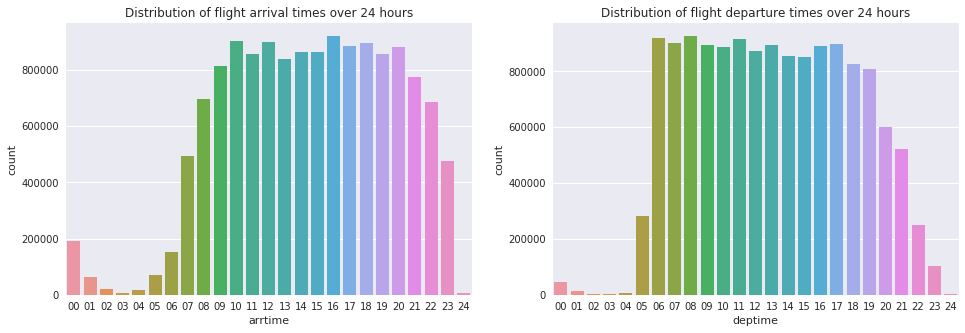

In [50]:
f, ax =plt.subplots(1, 2, figsize=(16, 5))

g = sns.barplot(x="arrtime", y="count", data=p_arrival_hour_grp, ax=ax[0])
g = sns.barplot(x="deptime", y="count", data=p_departure_hour_grp, ax=ax[1])

t1 = ax[0].set_title("Distribution of flight arrival times over 24 hours")
t2 = ax[1].set_title("Distribution of flight departure times over 24 hours")

Post midnight till about 4 in the morning, flight arrival and departure activity is significantly lower.

### Q6 .Do you see the worst delays at any certain times of the day?
Contrast DepTime, ArrTime with CRSDepTime, CRSArrTime (scheduled arrival and departure time; CRS is the Computer Reservation System)

In [51]:
cols_to_select = ["flightnum", "arrtime", "crsarrtime", "deptime", "crsdeptime"]
aircraft_subset = aircraft_df[cols_to_select]
aircraft_subset.limit(100).toPandas().head(5)

,flightnum,arrtime,crsarrtime,deptime,crsdeptime
0,2891,1341.0,1340,1232.0,1225
1,462,2043.0,2035,1918.0,1905
2,1229,2334.0,2300,2206.0,2130
3,1355,1356.0,1330,1230.0,1200
4,2278,957.0,1000,831.0,830


The worst delays are the flights that had the maximum deviation from the CRS time specified. A difference between these two columns could prove insightful.

If we want to see delays across a day, we can look at things in an hourly basis, and find the hour with the biggest distribution.

It also happens the CRS columns need to be cleaned and kept in the right format.

#### Arrival delays

In [74]:
# Converting the column ArrTime to string
cols = ["flightnum", "arrdelay", "crsarrtime"]
arrival_df = aircraft_df[cols]
arrival_df.dropna()

arrival_df = arrival_df.withColumn("crsarrtime", aircraft_df["crsarrtime"].cast(StringType()))

arrival_df = arrival_df.select("arrdelay",
                               lpad(arrival_df['crsarrtime'],4,'0').alias('crsarrtime'),
                               'flightnum')

Delays mean that the flight did not arrive earlier than the CRS time.

In [75]:
arrival_df = arrival_df[arrival_df["arrdelay"] > 0]

In [76]:
arrival_df = arrival_df.withColumn('crsarrhours', substring('crsarrtime', 1, 2))
arrival_df = arrival_df.withColumn('crsarrminutes', substring('crsarrtime', 3, 4))

arrival_df.limit(100).toPandas().head(5)

,arrdelay,crsarrtime,flightnum,crsarrhours,crsarrminutes
0,1,1340,2891,13,40
1,8,2035,462,20,35
2,34,2300,1229,23,00
3,26,1330,1355,13,30
4,3,1550,2386,15,50


In [98]:
arrdelay_grp = arrival_df.groupBy(["crsarrhours", "crsarrminutes"]).sum().toPandas()
arrdelay_grp_max = arrdelay_grp.groupby("crsarrhours", as_index=False).max()

#### Departure delays

The same pipeline applies to the departure delay dataframe as well.

In [100]:
# Converting the column ArrTime to string
cols = ["flightnum", "depdelay", "crsdeptime"]
departure_df = aircraft_df[cols]
departure_df.dropna()

departure_df = departure_df.withColumn("crsarrtime", aircraft_df["crsdeptime"].cast(StringType()))

departure_df = departure_df.select("depdelay",
                               lpad(departure_df['crsdeptime'],4,'0').alias('crsdeptime'),
                               'flightnum')

departure_df = departure_df[departure_df["depdelay"] > 0]

departure_df = departure_df.withColumn('crsdephours', substring('crsdeptime', 1, 2))
departure_df = departure_df.withColumn('crsdepminutes', substring('crsdeptime', 3, 4))

depdelay_grp = departure_df.groupBy(["crsdephours", "crsdepminutes"]).sum().toPandas()
depdelay_grp_max = depdelay_grp.groupby("crsdephours", as_index=False).max()

Visualise the distributions

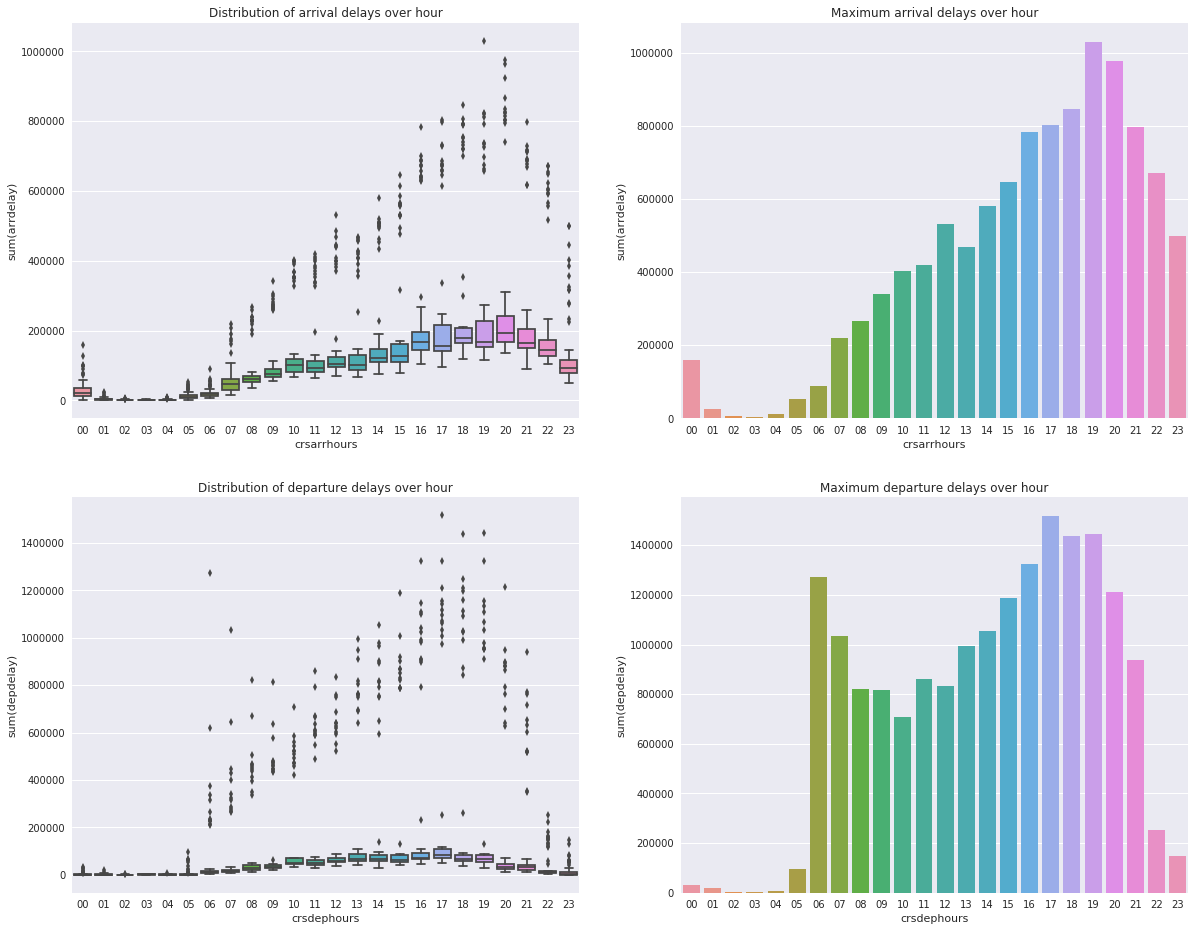

In [104]:
f, ax = plt.subplots(2, 2, figsize=(20, 16))
g1 = sns.boxplot(x="crsarrhours", y="sum(arrdelay)", data=arrdelay_grp, ax=ax[0][0])
g1 = sns.barplot(x="crsarrhours", y="sum(arrdelay)", data=arrdelay_grp_max, ax=ax[0][1])
g2 = sns.boxplot(x="crsdephours", y="sum(depdelay)", data=depdelay_grp, ax=ax[1][0])
g2 = sns.barplot(x="crsdephours", y="sum(depdelay)", data=depdelay_grp_max, ax=ax[1][1])

t1 = ax[0][0].set_title("Distribution of arrival delays over hour")
t2 = ax[0][1].set_title("Maximum arrival delays over hour")
t3 = ax[1][0].set_title("Distribution of departure delays over hour")
t4 = ax[1][1].set_title("Maximum departure delays over hour")
